In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
import matplotlib

# 设置全局字体
matplotlib.rcParams["font.family"] = "SimSun"

raw_data = pd.read_csv(r"data\qiyeshuju-4S间隔.csv", encoding="gbk")
raw_data.index = pd.to_datetime(raw_data["时间"])
raw_data.drop("时间", axis=1, inplace=True)

columns = raw_data.columns
print(columns)


Index(['右侧换火信号', 'CEMS出口烟尘($mg/m^{3}$)', 'CEMS出口一氧化氮($mg/m^{3}$)',
       'VA.SO2($mg/m^{3}$)', 'VA.NOX($mg/m^{3}$)', 'CEMS出口含氧(%)', 'VA.O2(%)',
       'NOX转换值($mg/m^{3}$)', '氨水泵B频率反馈(Hz)', '1#线氨水流量(L/h)', 'C泵频率反馈(Hz)',
       '反应塔入口温度', '1#线氨水调节阀(L/h)', '反应塔出口温度', 'CCF出口温度', '氨水分段设定反馈($m^{3}/h$)',
       'CCF6温度', 'CCF5温度', 'CCF4温度', 'CCF3温度', 'CCF2温度', '出口CEMS温度', 'CCF1温度',
       'CCF7温度', '喷氨压缩空气压力', 'CCF1差压', 'CCF2差压', 'CCF3差压', 'CCF4差压', 'CCF5差压',
       '反应塔差压', 'CCF6差压', 'B变频器电流(A)', 'A变频器电流(A)', 'B输出频率(Hz)',
       '氨逃逸小时均值($mg/m^{3}$)', 'A输出频率(Hz)', 'CCF7差压', '烟气量($Nm^{3}/h$)',
       'CCF出口压力', 'CEMS出口流量(m/s)', '22出口CEMS温度', '22CEMS出口烟尘($mg/m^{3}$)',
       '出口CEMS湿度(%)', '22烟气量($Nm^{3}/h$)', '右侧换火信号-数值'],
      dtype='object')


## New version of Prophet

In [41]:

# 选择一天的数据
print(raw_data.index)
one_data = raw_data["2024-01-01 00:00:00":"2024-01-01 23:59:59"]

test_data = one_data[[r"VA.NOX($mg/m^{3}$)"]]
test_data.columns = ["y"]
test_data

DatetimeIndex(['2023-12-11 18:48:28', '2023-12-11 18:48:32',
               '2023-12-11 18:48:36', '2023-12-11 18:48:40',
               '2023-12-11 18:48:44', '2023-12-11 18:48:48',
               '2023-12-11 18:48:52', '2023-12-11 18:48:56',
               '2023-12-11 18:49:00', '2023-12-11 18:49:04',
               ...
               '2024-01-12 17:09:32', '2024-01-12 17:09:36',
               '2024-01-12 17:09:40', '2024-01-12 17:09:44',
               '2024-01-12 17:09:48', '2024-01-12 17:09:52',
               '2024-01-12 17:09:56', '2024-01-12 17:10:00',
               '2024-01-12 17:10:04', '2024-01-12 17:10:08'],
              dtype='datetime64[ns]', name='时间', length=690336, freq=None)


,y
时间,
2024-01-01 00:00:00,1530.907349
2024-01-01 00:00:04,1543.034058
2024-01-01 00:00:08,1569.152710
2024-01-01 00:00:12,1580.701172
2024-01-01 00:00:16,1590.964355
...,...
2024-01-01 23:59:40,1272.953735
2024-01-01 23:59:44,1275.792358
2024-01-01 23:59:48,1278.235229


==========================================smooth freq done==========================================


<Axes: xlabel='时间'>

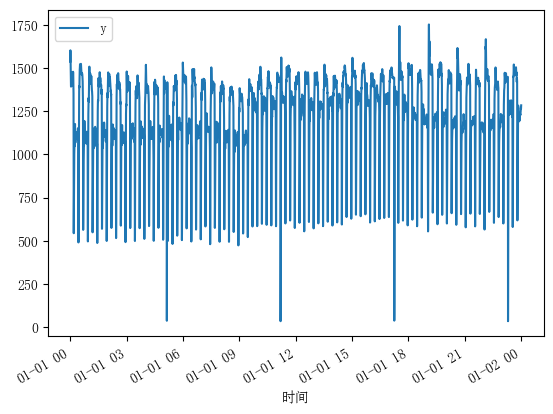

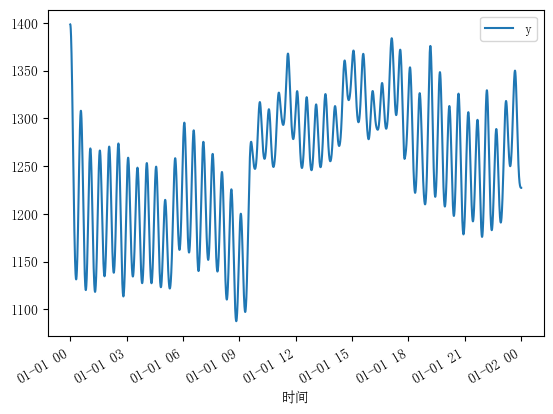

In [45]:
# 滤波平滑:
from scipy.ndimage import gaussian_filter
from copy import deepcopy


def do_smooth(data, sigma=1):
    """do data smooth and save figure in folder "smooth" """
    smoothed_data = deepcopy(data)
    data_smooth = gaussian_filter(data["y"], sigma)
    smoothed_data.loc[:,"y"] = data_smooth

    print("smooth freq done".center(100, "="))
    return smoothed_data

test_data.plot()
smooth_data = do_smooth(test_data, sigma=100)
smooth_data.plot()



In [27]:
# 训练集和测试集
new_time_index = pd.date_range("2021-01-01 00:00:00", freq="h", periods=len(test_data))
test_data.index = new_time_index
test_data.loc[:, "ds"] = new_time_index

n = len(new_time_index)

# 0.8作为训练集，0.2作为测试集
train_scale = 0.95
train = test_data[:int(n*train_scale)]
test = test_data[int(n*train_scale):]

# prophet模型
m = Prophet()
m.fit(train)


16:29:29 - cmdstanpy - INFO - Chain [1] start processing
16:29:32 - cmdstanpy - INFO - Chain [1] done processing


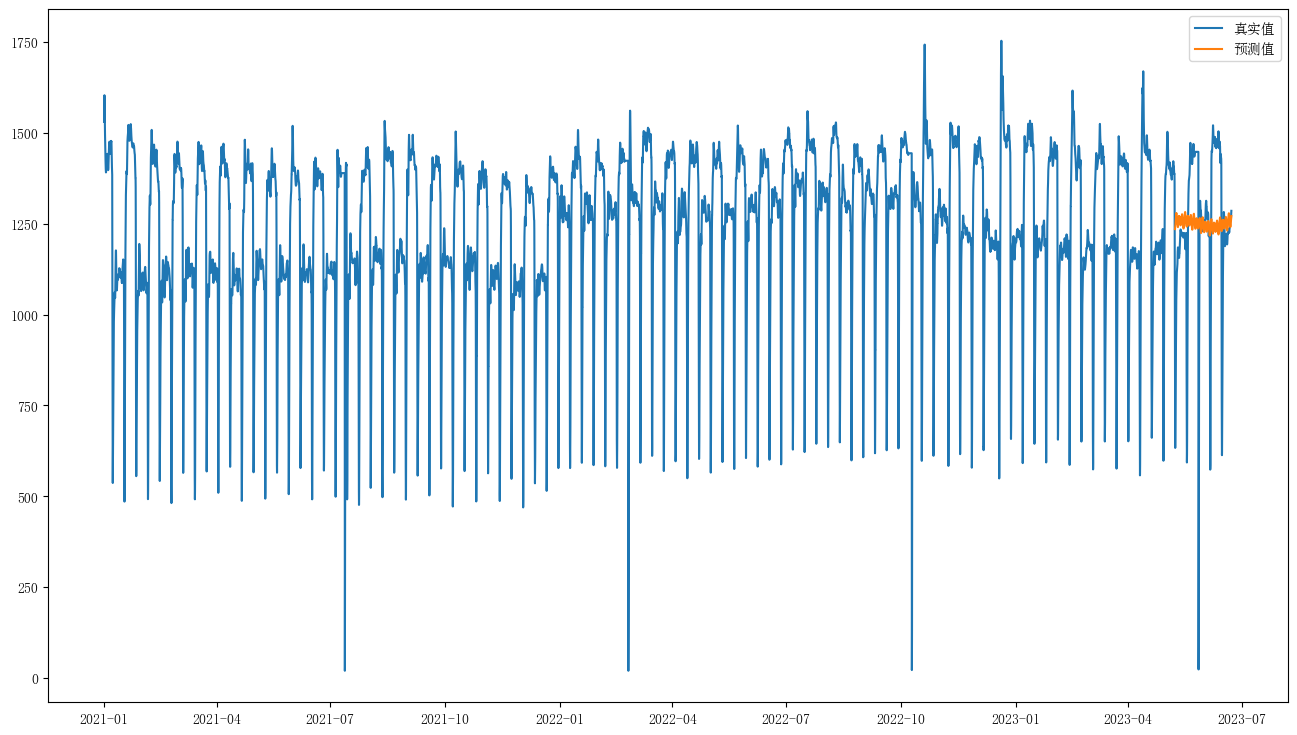

In [28]:
predict = m.predict(test)
predict.index = test.index
# m.plot_components(m.predict(test_data))


# draw the predict and real data 
plt.figure(figsize=(16, 9))
plt.plot(test_data["y"], label="真实值")
plt.plot(predict["yhat"], label="预测值")
plt.legend()
